In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os
print(os.getcwd())

/Users/basnugroho/notebooks/thesis


## 1. Persiapan Data ##

In [2]:
data = pd.read_excel('cleaned_dataset.xlsx')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              577 non-null    int64  
 1   Unnamed: 0.1            577 non-null    int64  
 2   Unnamed: 0.1.1          577 non-null    int64  
 3   Unnamed: 0.1.1.1        577 non-null    int64  
 4   Unnamed: 0.1.1.1.1      577 non-null    int64  
 5   Unnamed: 0.1.1.1.1.1    577 non-null    int64  
 6   Unnamed: 0.1.1.1.1.1.1  577 non-null    int64  
 7   id                      270 non-null    float64
 8   tweet                   577 non-null    object 
 9   isp                     223 non-null    object 
 10  score                   577 non-null    int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 49.7+ KB


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,id,tweet,isp,score
0,0,0,0,0,0,0,0,1.374183e+18,"<product_name> min cek dm , nanyak status kone...",biznet,0
1,1,1,1,1,1,1,1,1.374166e+18,"<product_name> udah min , hbs tweet trs",biznet,1
2,2,2,2,2,2,2,2,1.374153e+18,min cek koneksi internet <product_name>,biznet,0
3,3,3,3,3,3,3,3,1.374139e+18,<user_mention> <user_mention> dm mimin id pela...,biznet,0
4,4,4,4,4,4,4,4,1.374080e+18,<user_mention> <user_mention> dm mimin id kamu...,biznet,0


## 2. preprocess (cleaning) ##

In [3]:
import re
import string
import unicodedata
import nltk
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
import pickle

def clean_text(kata):    
    # remove full urls
    kata = re.sub("https*\S+", "<URL>", kata)
    
    #lowercase
    kata = kata.lower()
    
    # remove full hastag
    # kata = re.sub("#\S+", " ", kata)
    
    #remove number
    # kata = re.sub(r"\d+", "", kata)
    
    # remove link
    # kata = re.sub(r"http\S+", "", kata)
    
    # remove hashtag
    # kata = kata.replace('#', '')
    
    # remove space >, <
    kata = kata.replace('< ', '<')
    kata = kata.replace(' >', '>')
    
    # remove punctuation
    # kata = kata.translate(str.maketrans("","",string.punctuation))
    
    #remove extra spaces
    kata = kata.strip()
    
    # remove non ascii chars
    new_words = []
    for word in kata:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    kata = "".join(new_words)
    return kata

#replace string
def find_replace(kata, kalimat):
    list_to_replace = kalimat.split()
    for i,word in enumerate(list_to_replace):
        if kata in word:
            list_to_replace[i] = kata
    return " ".join(list_to_replace)

def remove_stopwords_id(kalimat):    
    # ambil stopword bawaan
    # stop_factory = StopWordRemoverFactory().get_stop_words()
    
    more_stopword = ['nih', 'sih', 'kok', 'hi', 'yah',
                'mohon', 'nya', 'yg', 'wkwk', 'wkwkwk', 'wkwkwkwk']

    # menggabungkan stopword
    #data = stop_factory + more_stopword
    data = stopwords_id + more_stopword

    dictionary = ArrayDictionary(data)
    string = StopWordRemover(dictionary)
    tokens = nltk.tokenize.word_tokenize(string.remove(kalimat))
    return(" ".join(tokens))

def stem_sastrawi(kalimat):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    return stemmer.stem(kalimat)

In [4]:
def replace_product(kata):
    kata = kata.lower()
    # from mention
    kata = re.sub("@biznet*\S+", "<PRODUCT_NAME>", kata)
    kata = re.sub("@indihome*\S+", "<PRODUCT_NAME>", kata)
    kata = re.sub("@di_cbn*\S+", "<PRODUCT_NAME>", kata)
    # from word
    kata = re.sub("indi*\S+", "<PRODUCT_NAME>", kata)
    kata = re.sub("indeh*\S+", "<PRODUCT_NAME>", kata)
    kata = re.sub("indieho*\S+", "<PRODUCT_NAME>", kata)
    return kata
    
def replace_provider(kata):
    kata = kata.lower()
    # from mention
    kata = re.sub("@telkom*\S+", "<PROVIDER_NAME>", kata)
    # from word
    kata = re.sub("indi*\S+", "<PROVIDER_NAME>", kata)
    kata = re.sub("telkomsel*\S+", "<PROVIDER_NAME>", kata)
    return kata

def replace_mention(kata):
    # remove full mentions
    kata = re.sub("@\S+", "<USER_MENTION>", kata)
    kata = kata.lower()
    return kata

def remove_bracket(kata):
    kata = re.sub("@\S+", "<USER_MENTION>", kata)

In [5]:
stopwords_id = ['yang',
 'untuk',
 'pada',
 'ke',
 'para',
 'namun',
 'menurut',
 'antara',
 'dia',
 'dua',
 'ia',
 'seperti',
 'jika',
 'jika',
 'sehingga',
 'kembali',
 'dan',
 'ini',
 'karena',
 'kepada',
 'oleh',
 'saat',
 'harus',
 'sementara',
 'setelah',
 'belum',
 'kami',
 'sekitar',
 'bagi',
 'serta',
 'dari',
 'telah',
 'sebagai',
 'masih',
 'hal',
 'ketika',
 'adalah',
 'itu',
 'dalam',
 'bisa',
 'bahwa',
 'atau',
 'hanya',
 'kita',
 'dengan',
 'akan',
 'juga',
 'ada',
 'mereka',
 'sudah',
 'saya',
 'terhadap',
 'secara',
 'agar',
 'lain',
 'anda',
 'begitu',
 'mengapa',
 'kenapa',
 'yaitu',
 'yakni',
 'daripada',
 'itulah',
 'lagi',
 'maka',
 'tentang',
 'demi',
 'dimana',
 'kemana',
 'pula',
 'sambil',
 'sebelum',
 'sesudah',
 'supaya',
 'guna',
 'kah',
 'pun',
 'sampai',
 'sedangkan',
 'selagi',
 'sementara',
 'tetapi',
 'apakah',
 'kecuali',
 'sebab',
 'selain',
 'seolah',
 'seraya',
 'seterusnya',
 'tanpa',
 'agak',
 'boleh',
 'dapat',
 'dsb',
 'dst',
 'dll',
 'dahulu',
 'dulunya',
 'anu',
 'demikian',
 'tapi',
 'ingin',
 'juga',
 'nggak',
 'mari',
 'nanti',
 'melainkan',
 'oh',
 'ok',
 'seharusnya',
 'sebetulnya',
 'setiap',
 'setidaknya',
 'sesuatu',
 'pasti',
 'saja',
 'toh',
 'ya',
 'walau',
 'tolong',
 'tentu',
 'amat',
 'apalagi',
 'bagaimanapun']
# # StopWordRemoverFactory().get_stop_words()

In [6]:
# replace provider/product
tweets = [remove_stopwords_id(replace_mention(replace_product(replace_provider(str(tweet))))) for tweet in data['tweet']]
data['tweet'] = tweets
data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,id,tweet,isp,score
0,0,0,0,0,0,0,0,1.374183e+18,"< product_name > min cek dm , nanyak status ko...",biznet,0
1,1,1,1,1,1,1,1,1.374166e+18,"< product_name > udah min , hbs tweet trs",biznet,1
2,2,2,2,2,2,2,2,1.374153e+18,min cek koneksi internet < product_name >,biznet,0
3,3,3,3,3,3,3,3,1.374139e+18,< user_mention > < user_mention > dm mimin id ...,biznet,0
4,4,4,4,4,4,4,4,1.374080e+18,< user_mention > < user_mention > dm mimin id ...,biznet,0


In [7]:
# remove stopwords
tweets = [clean_text(remove_stopwords_id(str(tweet))) for tweet in data['tweet']]
data['tweet'] = tweets
data.head(10) # data for next process

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,id,tweet,isp,score
0,0,0,0,0,0,0,0,1.374183e+18,"<product_name> min cek dm , nanyak status kone...",biznet,0
1,1,1,1,1,1,1,1,1.374166e+18,"<product_name> udah min , hbs tweet trs",biznet,1
2,2,2,2,2,2,2,2,1.374153e+18,min cek koneksi internet <product_name>,biznet,0
3,3,3,3,3,3,3,3,1.374139e+18,<user_mention> <user_mention> dm mimin id pela...,biznet,0
4,4,4,4,4,4,4,4,1.374080e+18,<user_mention> <user_mention> dm mimin id kamu...,biznet,0
5,5,5,5,5,5,5,5,1.374011e+18,<product_name> perumahan citra garden 1 blok g3,biznet,0
6,6,6,6,6,6,6,6,1.374009e+18,<user_mention> <user_mention> bantu mimin info...,biznet,0
7,7,7,7,7,7,7,7,1.373996e+18,<product_name> .. perumahan citra garden 1 ?,biznet,0
8,8,8,8,8,8,8,8,1.373991e+18,<product_name> halo mau tanya kalo utk pemasan...,biznet,0
9,9,9,9,9,9,9,9,1.373945e+18,"<product_name> <user_mention> gak , rekomendas...",biznet,0


In [8]:
data.to_excel('cleaned_dataset.xlsx')

In [9]:
## stemming sastrawi
# stemmed_tweets = [stem_sastrawi(tweet) for tweet in data['tweet']]
# data['tweet'] = tweets # data for next process
# data["tweet"].head(10)

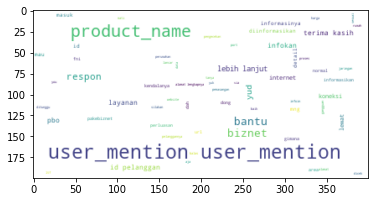

In [10]:
# generate and show the word cloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

corpus = data.loc[data['isp']=='biznet']['tweet'].tolist()
corpus_str = ' '.join(map(str, corpus))
stop_factory = StopWordRemoverFactory().get_stop_words()
more_stopword = ['daring', 'online', 'nih', 'sih', 'kok', 'hi', 'mimin', 'yah', 'cek', 'https', 'di', 'dm', 'di_cbn', 'mohon',
                'mohon', 'min', 'ka','ga','hari','t','co','nya', 'halo', 'kak', 'yg', 'hai', 'kamu', 'thanks', 'rri','melalui','udah', 
                'pagi']
my_stopwords = stop_factory + more_stopword
my_cloud = WordCloud(background_color='white', stopwords=my_stopwords).generate(corpus_str)
plt.imshow(my_cloud, interpolation='bilinear')

## 3 Word Embedding ##

## tfidf ##

In [11]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

In [12]:
tweets = data['tweet'].to_list()
vect.fit(tweets)

# sparse matrix
X = vect.fit_transform(tweets)

# transform to an array
my_array = X.toarray()
print(my_array)

#transofrm back to a dataframe, assign column values
X_df = pd.DataFrame(my_array, columns=vect.get_feature_names())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
#Save vectorizer.vocabulary_
pickle.dump(vect.vocabulary_,open("tfidf_model.pkl","wb"))

In [14]:
#!pip install cPickle

In [15]:
import joblib

joblib.dump(vect, 'vectorizer.pkl')
#joblib.dump(selector, 'selector.pkl')

['vectorizer.pkl']

In [16]:
# posisi kata ada negasi 


#word2vec, #fasttext, 
#itb perlu ekstaksi fitur

## train/test split ##

In [17]:
X_df['score'] = data['score']

In [18]:
# training: 70%-80% of the whole data
from sklearn.model_selection import train_test_split
y = X_df['score']
X = X_df.drop('score', axis=1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

## Logistic Regression ##

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

log_reg = LogisticRegression(C=0.9).fit(X, y)

y_predicted = log_reg.predict(X_test)
print("training accuracy: {0:.2f}%".format(log_reg.score(X_train, y_train)*100))
print("test accuracy: {0:.2f}%".format(log_reg.score(X_test, y_test)*100))

# y_predicted = log_reg.predict(X_test)
# print("test accuracy_score: {0:.2f}%".format(accuracy_score(y_test, y_predicted)*100))
print('\nconfussion matrix:')
print(confusion_matrix(y_test, y_predicted)/len(y_test))
print('\nclassification report:')
print(classification_report(y_test, y_predicted))

training accuracy: 95.04%
test accuracy: 93.68%

confussion matrix:
[[0.32758621 0.         0.00574713]
 [0.00574713 0.33333333 0.00574713]
 [0.01724138 0.02873563 0.27586207]]

classification report:
              precision    recall  f1-score   support

          -1       0.93      0.98      0.96        58
           0       0.92      0.97      0.94        60
           1       0.96      0.86      0.91        56

    accuracy                           0.94       174
   macro avg       0.94      0.94      0.94       174
weighted avg       0.94      0.94      0.94       174



## save/load Logistic Regression model ##

In [21]:
# 4 Hasil Sentiment
# save model
import pickle

filename = 'inet_model.sav'
pickle.dump(log_reg, open(filename, 'wb'))

In [22]:
# load the model from disk
loaded_model = pickle.load(open('inet_model.sav', 'rb'))
result = loaded_model.score(X_test, y_test)
print("test accuracy: {0:.2f}%".format(result*100))

test accuracy: 93.68%


## try the model ##

In [23]:
text = "indihome lagi stabil"
cleaned_text = remove_stopwords_id(clean_text(text))
print(cleaned_text)

indihome stabil


In [24]:
load_vect = joblib.load('vectorizer.pkl')
transformed_text = load_vect.transform(pd.Series([cleaned_text]))
transformed_text_arr = transformed_text.toarray()
transformed_text_arr_df = pd.DataFrame(transformed_text_arr, columns=load_vect.get_feature_names())

In [25]:
part = loaded_model.predict(transformed_text_arr_df[:])
print(part[0])

1


## 4. Klasifikasi Gangguan ##

In [26]:
# load the model from disk
loaded_model = pickle.load(open('inet_model.sav', 'rb'))
result = loaded_model.score(X_test, y_test)
print("test accuracy: {0:.2f}%".format(result*100))

test accuracy: 93.68%


In [27]:
text = "int mati butuh bantuan"
cleaned_text = remove_stopwords_id((text))
print(cleaned_text)

# sparse matrix
cleaned_text_ls = pd.Series([cleaned_text])
cleaned_text_vect = vect.transform(cleaned_text_ls)

# transform to an array
cleaned_text_array = cleaned_text_vect.toarray()

#transofrm back to a dataframe, assign column values
cleaned_text_num_df = pd.DataFrame(cleaned_text_array, columns=vect.get_feature_names())

part = loaded_model.predict(cleaned_text_num_df[:])
print(part[0])

int mati butuh bantuan
0


In [28]:
# kata = "@IndiHomeCare hallo saya mao reset kaga bisa ya  https://t.co/zccKt8Qo9m"
# kata = re.sub("@indi\S+", "<PRODUCT_NAME>", kata.lower())
# kata

## Logistic Regression with predict_proba ##

In [29]:
y_predicted = log_reg.predict_proba(X_test)

In [30]:
loaded_model.predict_proba(transformed_text_arr_df[:])

array([[0.34750133, 0.26582863, 0.38667004]])

## Non-Linear SVC ##

In [31]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

In [32]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

svm = SVC(C=0.6)
svm.fit(X_train, y_train)

# y_predicted = log_reg.predict(X_test)
print("training accuracy: {0:.2f}%".format(svm.score(X_train, y_train)*100))
print("test accuracy: {0:.2f}%".format(svm.score(X_test, y_test)*100))

print('\nconfussion matrix:')
print(confusion_matrix(y_test, y_predicted)/len(y_test))
print('\nclassification report:')
print(classification_report(y_test, y_predicted))

training accuracy: 97.77%
test accuracy: 78.16%

confussion matrix:


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

## Linear SVM ##

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

lin_svm = LinearSVC(C=0.002)
lin_svm.fit(X_train, y_train)

# y_predicted = log_reg.predict(X_test)
print("training accuracy: {0:.2f}%".format(lin_svm.score(X_train, y_train)*100))
print("test accuracy: {0:.2f}%".format(lin_svm.score(X_test, y_test)*100))

print('\nconfussion matrix:')
print(confusion_matrix(y_test, y_predicted)/len(y_test))
print('\nclassification report:')
print(classification_report(y_test, y_predicted))

In [ ]:
# coba-coba
text = "aku suka internet stabil"
cleaned_text = remove_stopwords_id(clean_text(text))
print(cleaned_text)

In [ ]:
load_vect = joblib.load('vectorizer.pkl')

In [ ]:
transformed_text = load_vect.transform(pd.Series([cleaned_text]))
transformed_text_arr = transformed_text.toarray()
transformed_text_arr_df = pd.DataFrame(transformed_text_arr, columns=load_vect.get_feature_names())

In [ ]:
lin_svm.predict(transformed_text_arr_df[:])[0]

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

# #Load tfidf
# transformer = TfidfTransformer()
# loaded_vec = CountVectorizer(decode_error="replace",vocabulary=pickle.load(open("tfidf_model.pkl", "rb")))

# cleaned_text_ls = pd.Series([cleaned_text])
# tfidf = transformer.fit_transform(loaded_vec.fit_transform(cleaned_text_ls))

# # transform to an array
# cleaned_text_array = tfidf.toarray()

# #transofrm back to a dataframe, assign column values
# cleaned_text_num_df = pd.DataFrame(cleaned_text_array, columns=vect.get_feature_names())

In [ ]:
import numpy as np
# the words corresponding to the different features are loaded into the variable vocab. 
# For example, since vocab[100] is "think", that means feature 100 corresponds to the number of times the 
# word "think" appeared in that movie review.
# Get the indices of the sorted cofficients
inds_ascending = np.argsort(log_reg.coef_.flatten()) 
inds_descending = inds_ascending[::-1]

# # Print the most positive words
# print("Most positive words: ", end="")
# for i in range(5):
#     print(X_train[inds_descending[i]], end=", ")
# print("\n")

# # Print most negative words
# print("Most negative words: ", end="")
# for i in range(5):
#     print(X_train[inds_ascending[i]], end=", ")
# print("\n")

inds_ascending

In [ ]:
inds_descending

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features=1000, ngram_range=(1, 2))

In [ ]:
tweets = data['tweet'].to_list()
vect.fit(tweets)

# sparse matrix
X = vect.transform(tweets)

# transform to an array
my_array = X.toarray()
print(my_array)

#transofrm back to a dataframe, assign column values
X_df = pd.DataFrame(my_array, columns=vect.get_feature_names())

In [ ]:
X_df.iloc[:,:-1]